<img src="qr-code-to-github-repo.svg" />

<center>https://github.com/NIPE-SYSTEMS/support-vector-machine</center>

# Support Vector Machine (Large Margin Classification)

<img src="machine-learning-inside.gif" />

## Table Of Contents

1. Simple SVM example with kernels
2. .... etc.

## Boring stuff ...

In [1]:
!pip install plotly

In [2]:
# importing required modules
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
import scipy.optimize
import sklearn.svm
import pandas as pd
import plotly.plotly as py
import plotly.graph_objs as go

# some high DPI settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Training set

Generating a training set from random values of a merged multivariate normal distribution. Because the generation is inorder the training set is shuffled after generation.

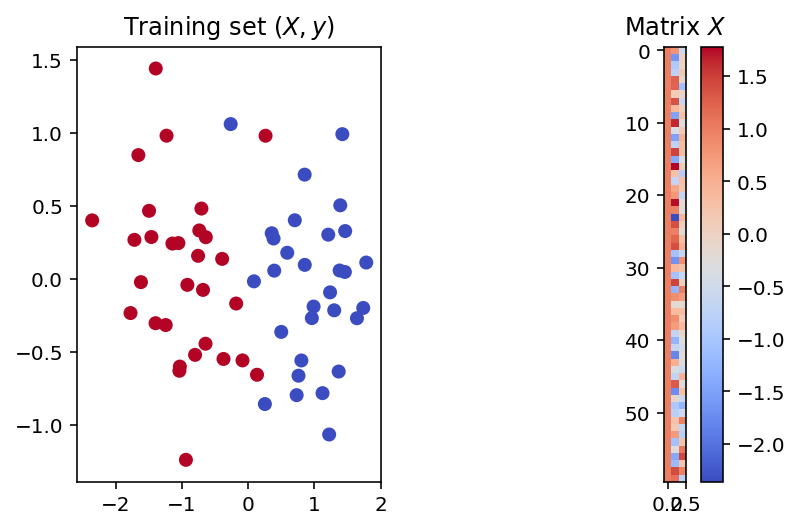

In [3]:
gaussian2d = lambda x, y, sigma, n: (np.random.normal(x, sigma, n), np.random.normal(y, sigma, n))

m = 60; half_m = int(m / 2)
sigma = 0.5

X = np.concatenate((
    np.array(gaussian2d(1, 0, sigma, half_m)).T,
    np.array(gaussian2d(-1, 0, sigma, half_m)).T
), axis=0)

y = np.concatenate((
    np.repeat(0, half_m),
    np.repeat(1, half_m)
), axis=0)

permutation = np.eye(m)
np.random.shuffle(permutation)

X = np.matmul(permutation, X)
y = np.matmul(permutation, y)

X = np.c_[ np.ones((m, 1)), X ]

plt.subplot(1, 2, 1)
plt.scatter(X[:, 1], X[:, 2], c=y, cmap=plt.cm.coolwarm)
plt.title("Training set $(X, y)$")

plt.subplot(1, 2, 2)
plt.imshow(X, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.title("Matrix $X$")
plt.show()

# Gaussian Kernel

$$k(x, l) = \exp\Bigg(- \frac{\big\Vert x - l \big\Vert^2}{2\sigma^2}\Bigg)$$

# Feature Matrix

Given a training set $x^{(0)}, x^{(1)}, \dots, x^{(m)} \in \mathbb{R}^{m+1}$, define $l^{(0)} = x^{(0)}, l^{(1)} = x^{(1)}, \dots, l^{(m)} = x^{(m)} \in \mathbb{R}^{m+1}$.

Define the feature matrix $F$ so that $f_{ij} = k(x^{(j)}, l^{(i)}) = \exp\Big(- \frac{\Vert x^{(j)} - l^{(i)} \Vert^2}{2\sigma^2}\Big)$.

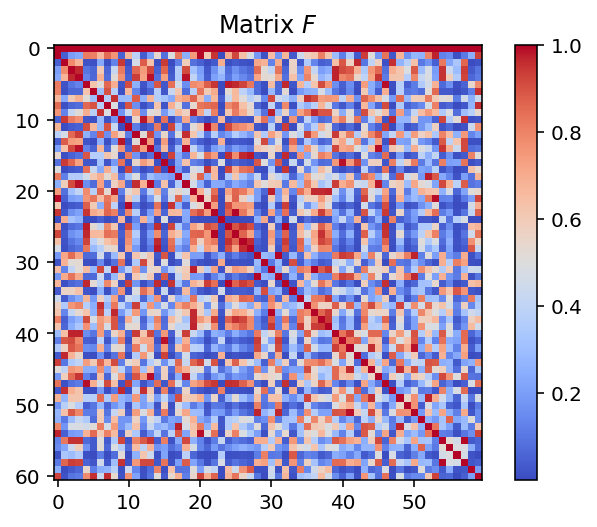

In [4]:
kernel = lambda x, l, sigma: np.exp(- (LA.norm(x - l, ord=2)**2) / (2 * sigma**2))

m = X.shape[0]

vectorized_kernel = np.vectorize(lambda i, j: kernel(X[i], X[j - 1], 1))
F = np.fromfunction(lambda j, i: vectorized_kernel(i, j), shape=(m + 1, m), dtype=int)
F[0, :] = 1

plt.imshow(F, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.title("Matrix $F$")
plt.show()

# Helper functions (Sigmoid, Hypothesis, Costs)

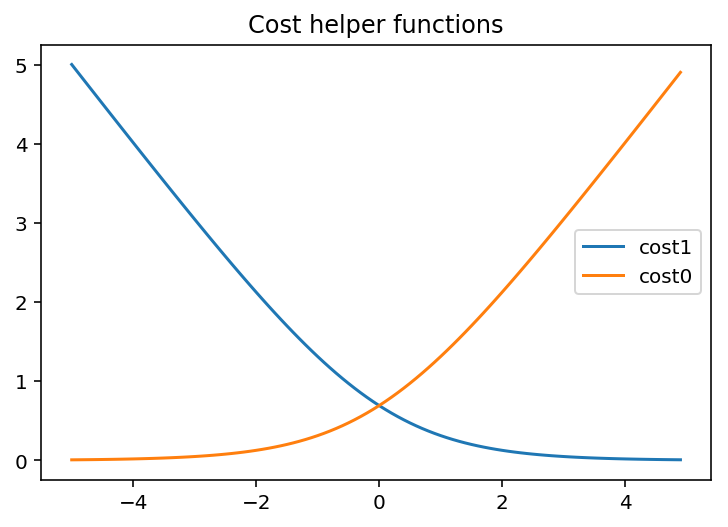

In [5]:
x = np.arange(-5, 5, 0.1)

g = lambda z: 1 / (1 + np.exp(-z))       # sigmoid function g
h = lambda theta, x: g(np.dot(theta, x)) # hypothesis

cost1 = lambda z: -np.log(g(z))     # cost function for y = 1
cost0 = lambda z: -np.log(1 - g(z)) # cost function for y = 0

plt.plot(x, cost1(x), label="cost1")
plt.plot(x, cost0(x), label="cost0")
plt.legend()
plt.title("Cost helper functions")
plt.show()

# Cost function *J*

In [6]:
def J(theta, F, y, C):
    z = np.dot(theta, F)
    c1 = cost1(z)
    c0 = cost0(z)
    sum1 = np.dot(c1, y)
    sum0 = np.dot(c0, (1 - y))
    return C * (sum1 + sum0) + 0.5 * LA.norm(theta[1:])**2

# Finding a minimum

We will get a minimum $\theta$ by minimizing the cost function. This $\theta$ is the normal vector of the decision boundary.

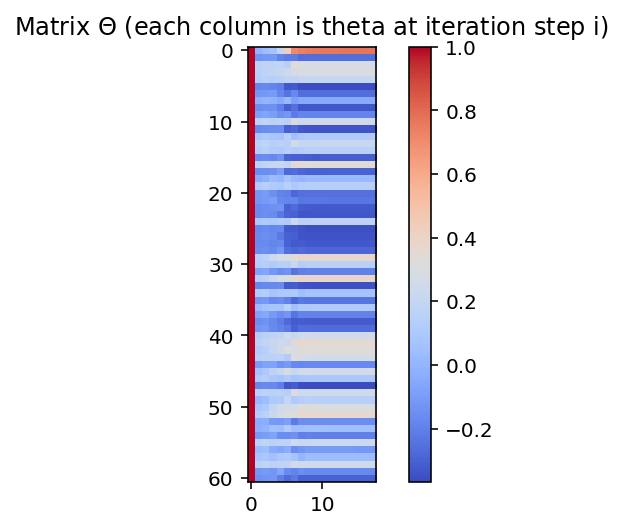

In [7]:
m = X.shape[0]
theta_matrix = np.ones(shape=(m + 1, 1))

def callback(theta):
    global theta_matrix
    theta_matrix = np.c_[ theta_matrix, theta ]

minimum = scipy.optimize.minimize(
    lambda theta: J(np.array(theta), F, y, C=1), x0=(0,)*(m + 1),
    callback=callback
)

theta = minimum.x

plt.imshow(theta_matrix, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.title("Matrix $\Theta$ (each column is theta at iteration step i)")
plt.show()

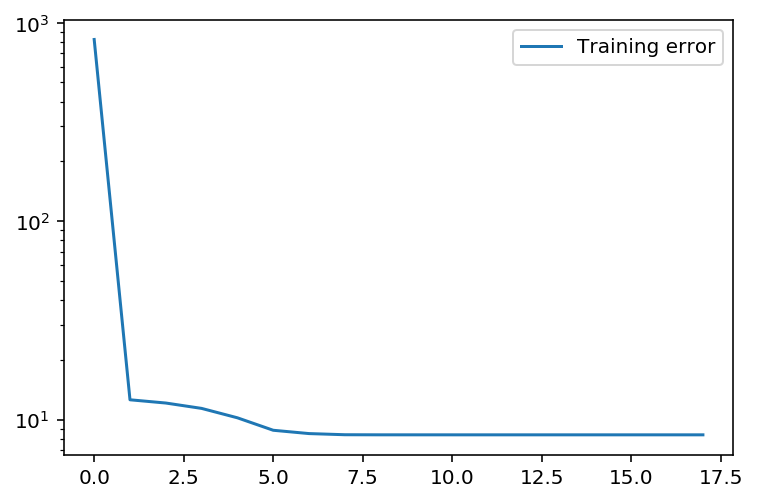

In [8]:
training_error = np.apply_along_axis(lambda theta: J(np.array(theta), F, y, C=1), axis=0, arr=theta_matrix)

plt.semilogy(training_error, label="Training error")
plt.legend()
plt.show()

In [9]:
xx, yy = np.meshgrid(np.arange(-5, 5, 0.1), np.arange(-5, 5, 0.1))

m_mesh = xx.ravel().shape[0]
X_mesh = np.c_[ np.ones((m_mesh, 1)), xx.ravel(), yy.ravel() ]

vectorized_kernel = np.vectorize(lambda i, j: kernel(X_mesh[i], X[j - 1], 1))
F = np.fromfunction(lambda j, i: vectorized_kernel(i, j), shape=(m + 1, m_mesh), dtype=int)
F[0, :] = 1

Z = np.dot(theta, F)

py.iplot([ go.Surface(x=xx, y=yy, z=Z.reshape(xx.shape))])

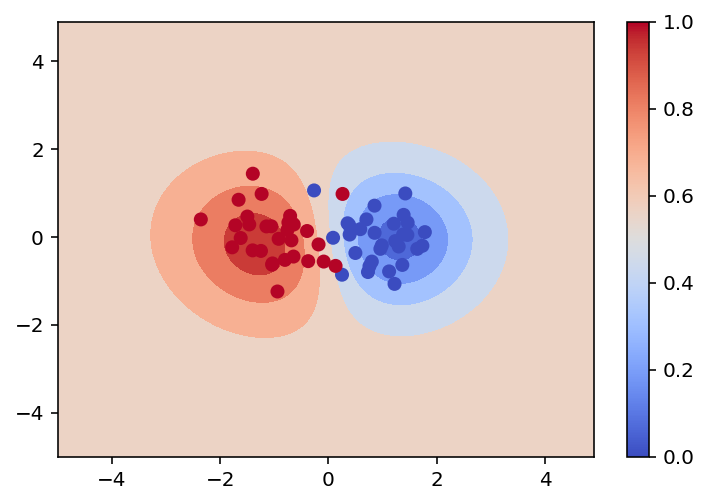

In [10]:
plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.coolwarm)
plt.scatter(X[:, 1], X[:, 2], c=y, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.show()

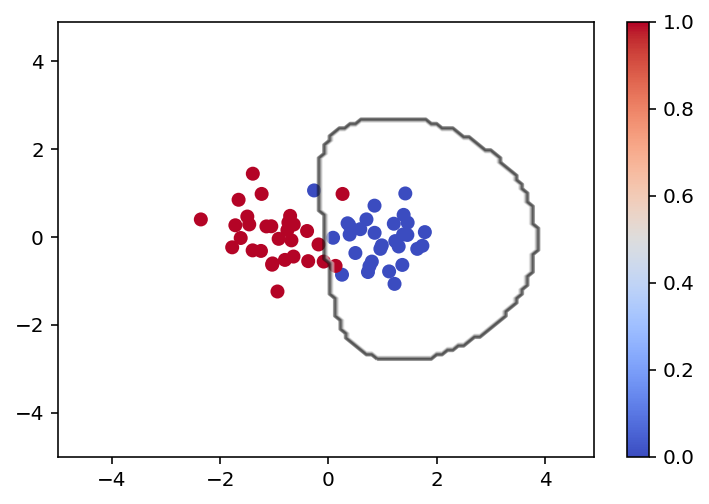

In [11]:
Z_classes = np.vectorize(lambda z: 1 if z > 0.5 else 0)(Z.reshape(xx.shape))

plt.contour(xx, yy, Z_classes, cmap=plt.cm.binary, alpha=0.35)
plt.scatter(X[:, 1], X[:, 2], c=y, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.show()

In [12]:
np.linspace(0, 1, 10)[5:]

array([0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

## Training set

## Cost function

$$\min_{\theta} C \sum_{i = 1}^{m} \Big[ y^{(i)} \text{cost}_1\big(\theta^T x^{(i)}\big) + \big(1 - y^{(i)}\big) \text{cost}_0\big(\theta^T x^{(i)}\big) \Big] + \frac{1}{2} \sum_{j = 1}^{n}\theta^2_j$$

$$= \min_{\theta} C \sum_{i = 1}^{m} \Big[ y^{(i)} \text{cost}_1\big(\theta^T x^{(i)}\big) \Big] + C \sum_{i = 1}^{m} \Big[ \big(1 - y^{(i)}\big) \text{cost}_0\big(\theta^T x^{(i)}\big) \Big] + \frac{1}{2} \sum_{j = 1}^{n}\theta^2_j$$

# Some fun with sklearn